In [1]:
## first line of code is to clear R's memory
rm(list=ls())

In [2]:
#libraries
if (!requireNamespace("EnsDb.Hsapiens.v86", quietly = TRUE))
  BiocManager::install("EnsDb.Hsapiens.v86")
library(Signac)
library(Seurat)
library(rtracklayer)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(readr)
library(qs)
library(dplyr)
library(stringr)
library(Azimuth)
library(harmony)
library(cicero)
library(SeuratWrappers)
library(BSgenome.Hsapiens.UCSC.hg38)
library(JASPAR2020)
library(TFBSTools)


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Loading required package: SeuratObject

Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.3.1"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')

Loading required package: GenomicRange

In [5]:
file = "GSE184462_merged_1_10"          

In [7]:
#####################
#Read Initial Seurat Object and filter it
###################
path <- paste("complete/", file, "_newpeaks.rds", sep = "")
seurat_object = readRDS(path)
 
#Add barcode to metadata
seurat_object$barcode <- Cells(seurat_object)

#####################
#Annotation
###################
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

# change to UCSC style since the data was mapped to hg38
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(seurat_object) <- annotations
    


Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

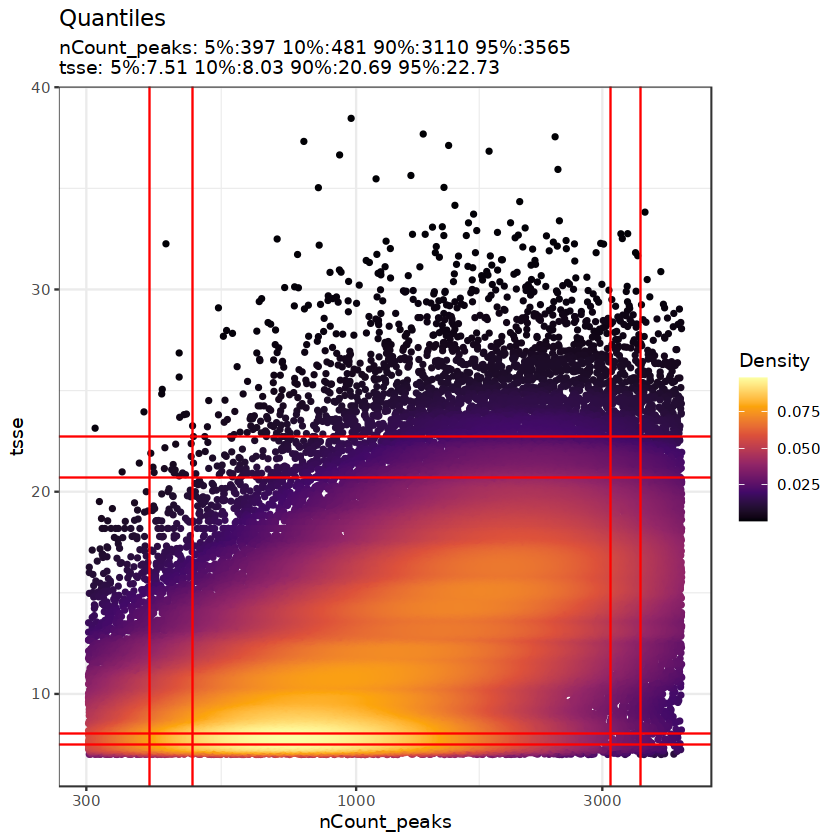

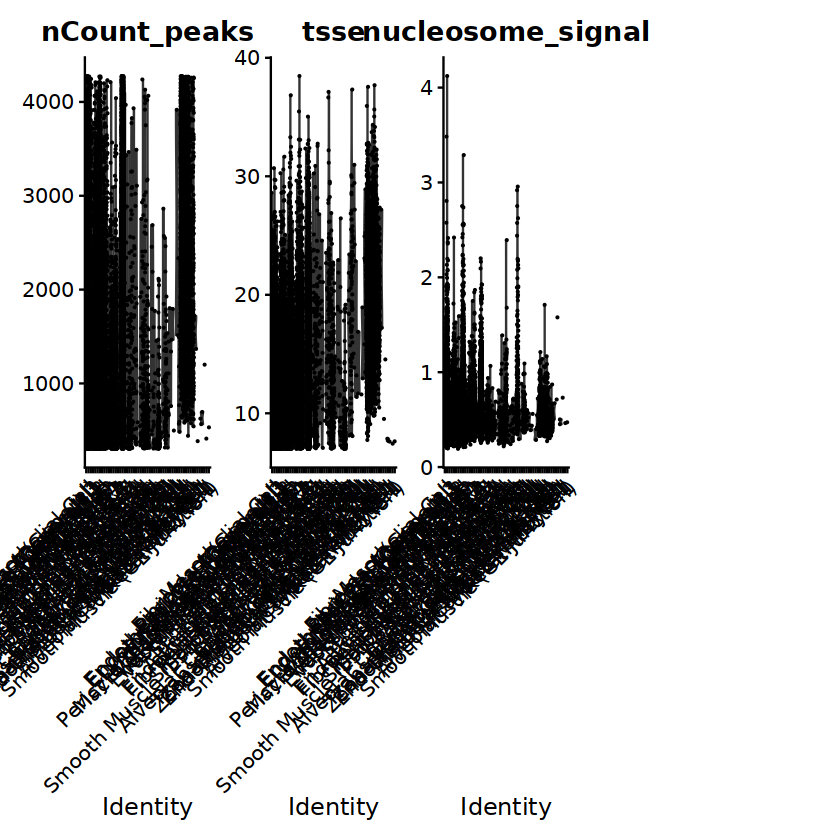

In [22]:
#####################
#QC Metrics
###################
# compute nucleosome signal score per cell
seurat_object <- NucleosomeSignal(object = seurat_object)

# compute TSS enrichment score per cell
seurat_object <- TSSEnrichment(object = seurat_object, fast = FALSE)

DensityScatter(seurat_object, x = 'nCount_peaks', y = 'tsse', log_x = TRUE, quantiles = TRUE)

VlnPlot(
  object = seurat_object,
  features = c('nCount_peaks', 'tsse', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

In [ ]:
DensityScatter(seurat_object, x = 'nCount_peaks', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)


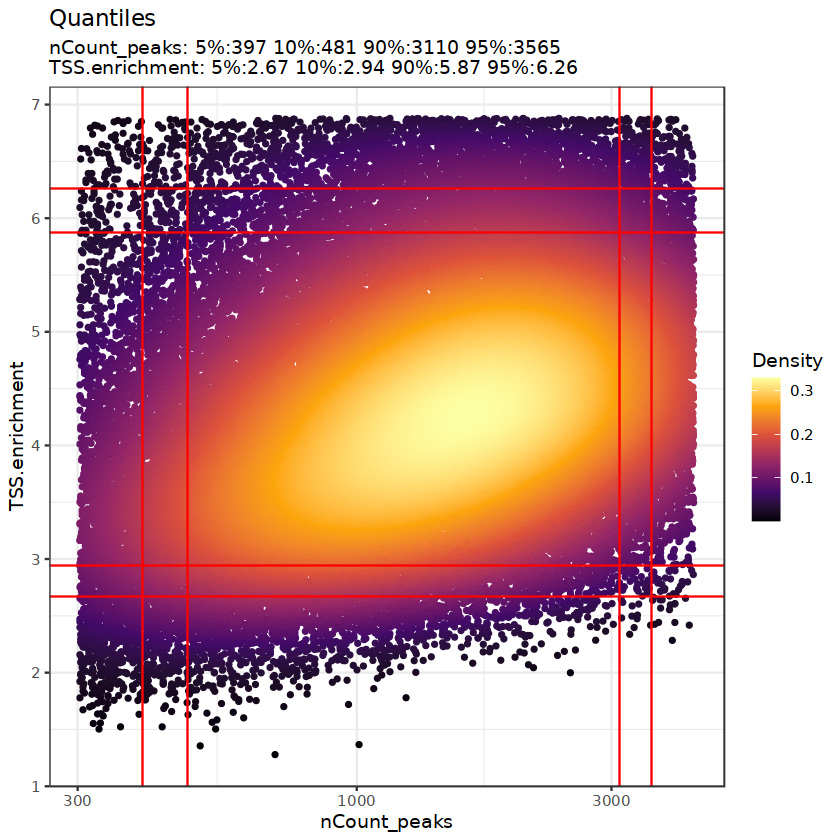

In [23]:
#filtering out bad reads
seurat_object <- subset(
    x = seurat_object,
    subset = nCount_peaks < 4277 &
    nCount_peaks > 302 &
    TSS.enrichment < 6.88
)

DensityScatter(seurat_object, x = 'nCount_peaks', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)



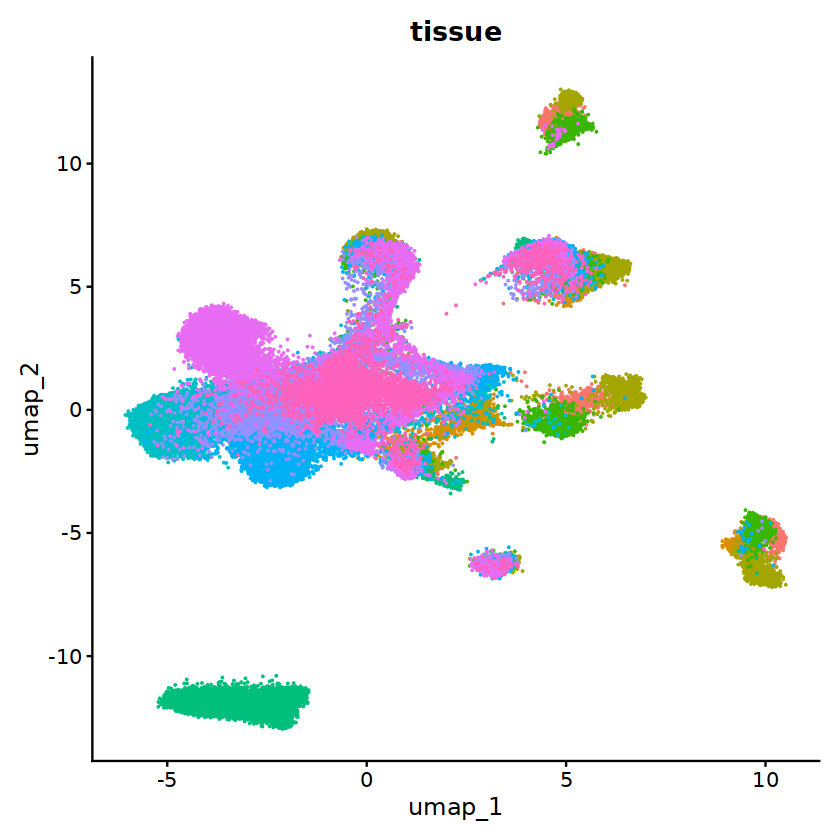

In [24]:
##########################
#Normalization and linear dimensional reduction
#########################
seurat_object <- RunTFIDF(seurat_object)
seurat_object <- FindTopFeatures(seurat_object, min.cutoff = 'q50')
seurat_object <- RunSVD(seurat_object)

DepthCor(seurat_object)

##########################
#Non-linear dimension reduction and clustering
#########################
#seurat_object <- RunHarmony(seurat_object, group.by.vars = "tissue", reduction = 'lsi', assay.use = 'peaks', project.dim = FALSE)
seurat_object <- RunUMAP(seurat_object, reduction = "lsi", dims = 2:30)
seurat_object <- FindNeighbors(object = seurat_object, reduction = 'lsi', dims = 2:30)
seurat_object <- FindClusters(object = seurat_object, verbose = FALSE, algorithm = 3)
DimPlot(object = seurat_object, group.by = 'tissue') + NoLegend()



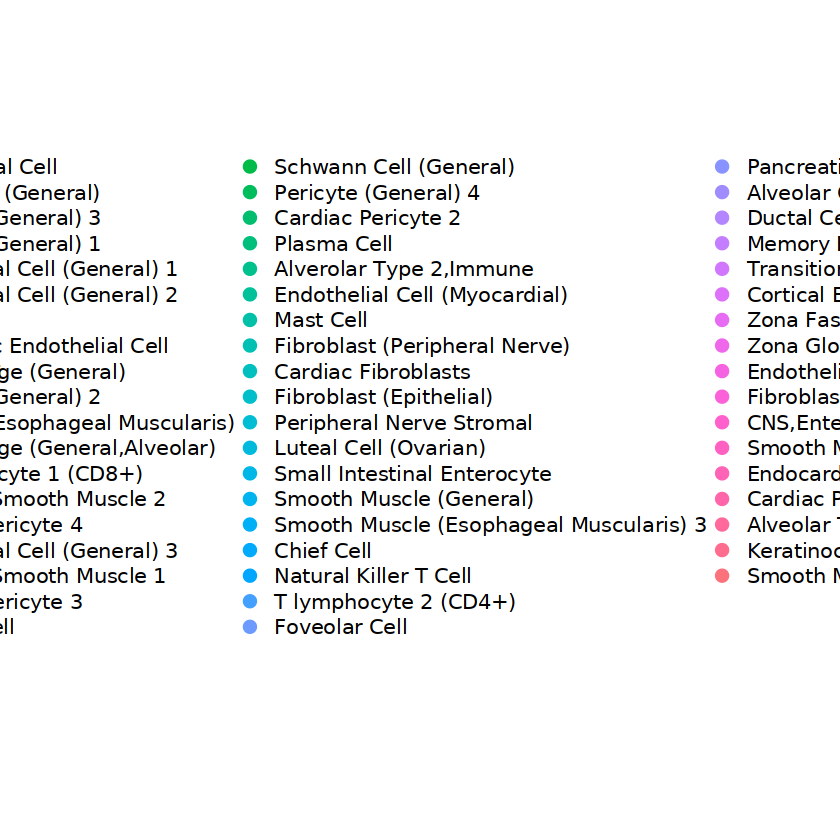

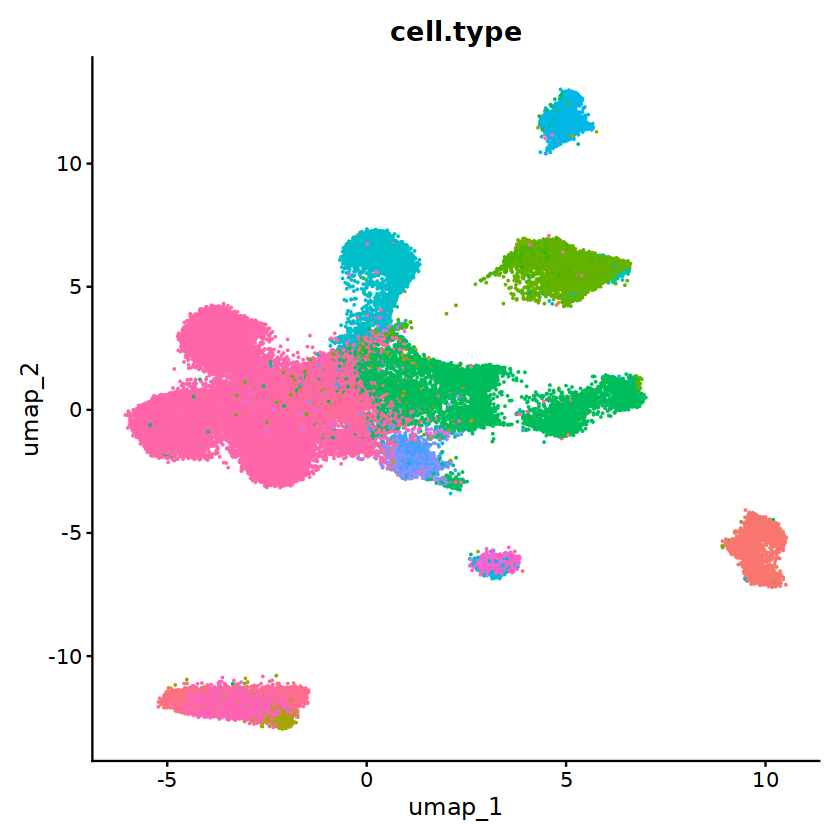

In [25]:
DimPlot(object = seurat_object, label = TRUE)
DimPlot(object = seurat_object, group.by = 'cell.type') + NoLegend()

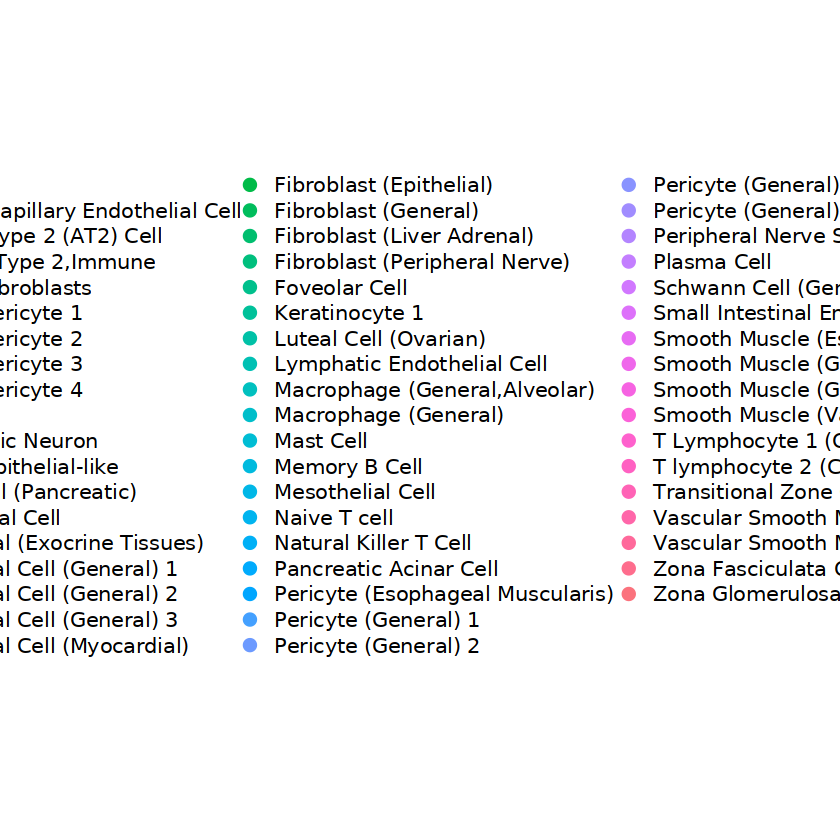

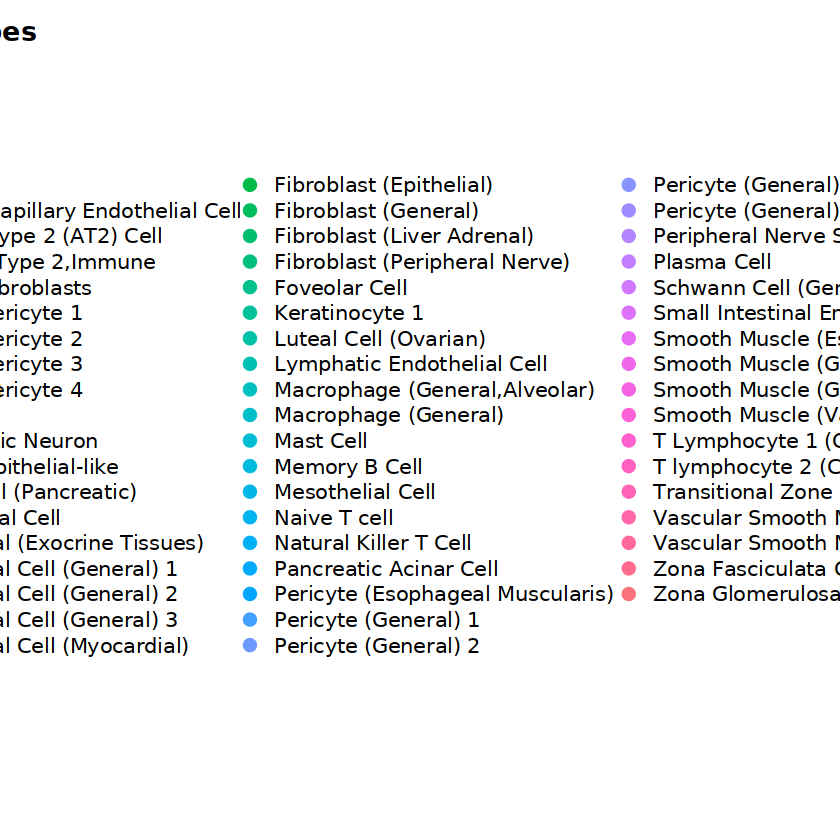

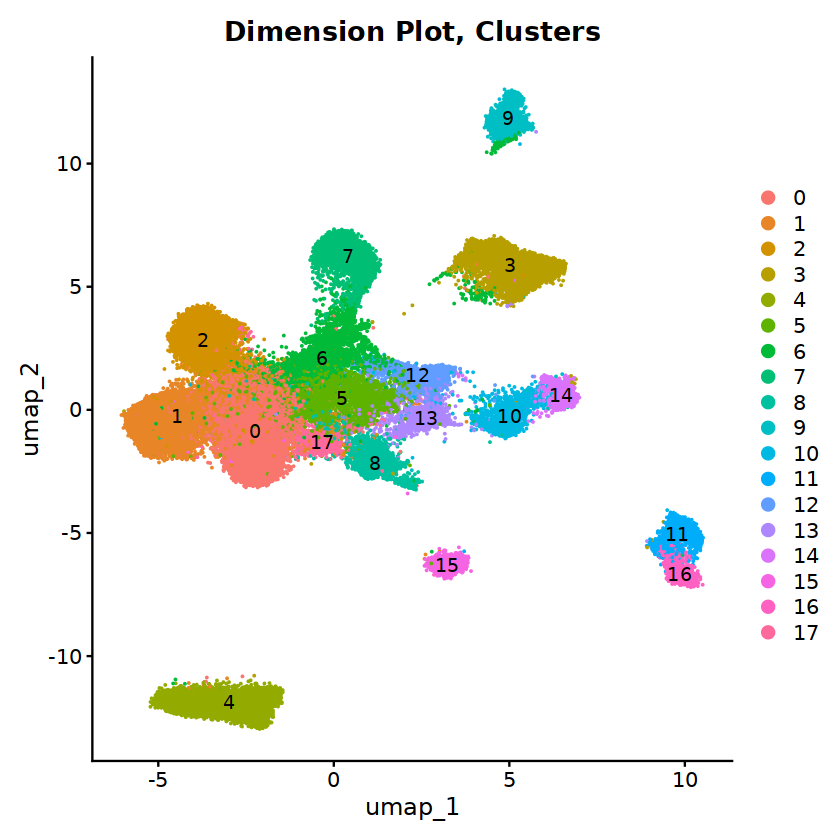

In [27]:
cluster_plot <- DimPlot(object = seurat_object, group.by = 'cell.type') 
cluster_plot_labeled <- DimPlot(object = seurat_object, label=TRUE, group.by = 'cell.type') + ggtitle("Dimension Plot, Cell.types")
cluster_plot_clusters <- DimPlot(object = seurat_object, label=TRUE, group.by = 'seurat_clusters') + ggtitle("Dimension Plot, Clusters")

cluster_plot
cluster_plot_labeled
cluster_plot_clusters

In [ ]:
#Print single cellt types
for (i in seq(1,50)){

ct <- unique(seurat_object$cell.type)[i]
st <- subset( x = seurat_object, subset = cell.type == ct)
ct
p1 <- DimPlot(object = st, group.by = "seurat_clusters", label = TRUE) + NoLegend() + ggtitle(ct)

    
print(p1)
    
}

[1] "Mesothelial Cell"

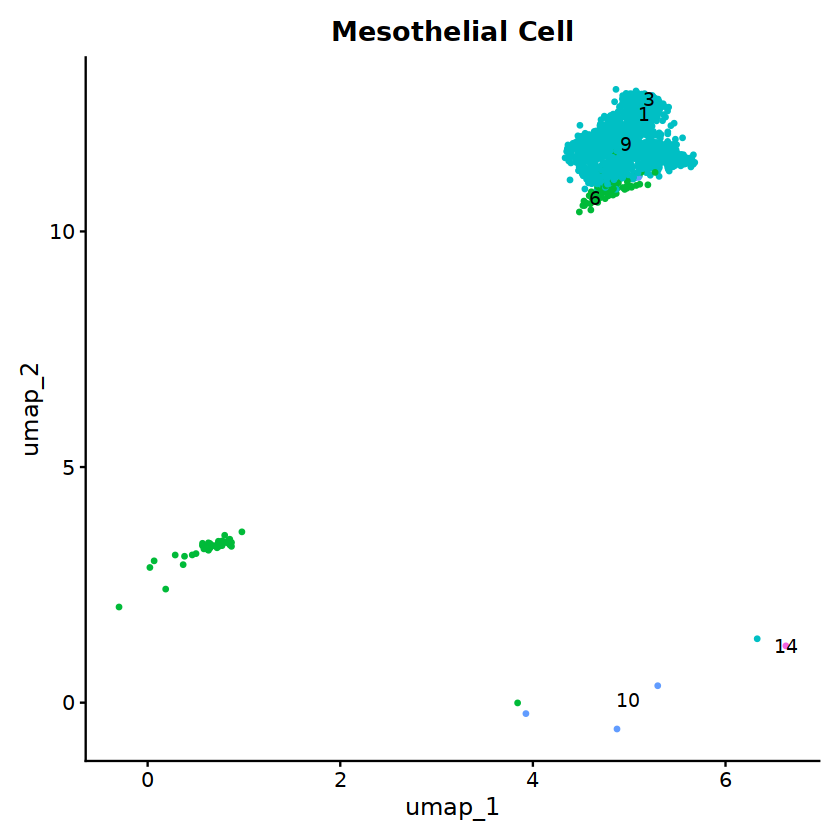

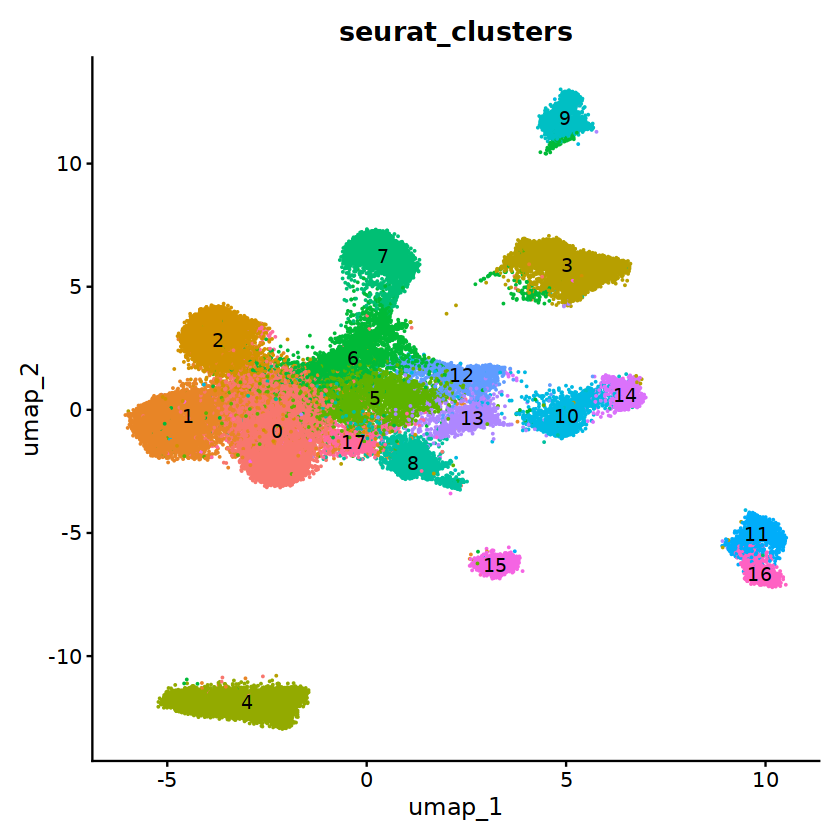

In [28]:
ct <- unique(seurat_object$cell.type)[1]
st <- subset( x = seurat_object, subset = cell.type == ct)
ct
p1 <- DimPlot(object = st, group.by = "seurat_clusters", label = TRUE) + NoLegend() + ggtitle(ct)

    
print(p1)
DimPlot(object = seurat_object, group.by = "seurat_clusters", label = TRUE) + NoLegend()

In [ ]:
##########################
#Create a gene activity matrix
#########################
gene.activities <- GeneActivity(seurat_object)
# add the gene activity matrix to the Seurat object as a new assay and normalize it
seurat_object[['RNA']] <- CreateAssayObject(counts = gene.activities)

seurat_object <- NormalizeData(
  object = seurat_object,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(seurat_object$nCount_RNA)
)



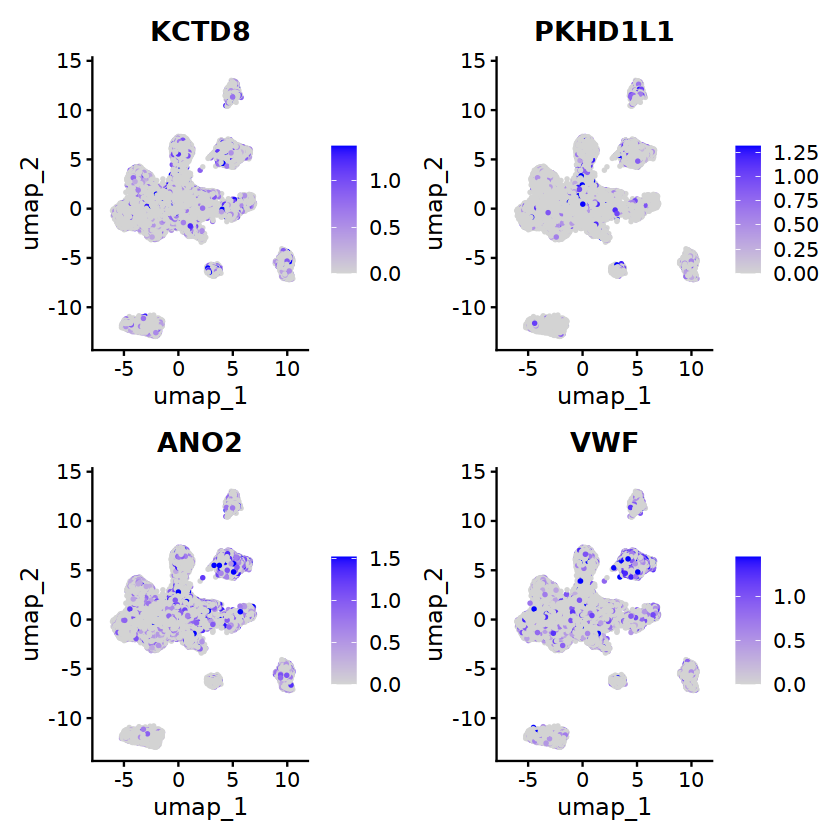

In [31]:
DefaultAssay(seurat_object) <- 'RNA'

fp <-FeaturePlot(
  object = seurat_object,
  features = c('KCTD8', 'PKHD1L1', "ANO2", "VWF"),
  pt.size = 0.5,
  max.cutoff = 'q95',
  ncol = 2
)
fp
#Fibroblasts: VIM, PDGFRA
#Adipocyte: LEP, HOXC8
#Endothel: LDB2, JAM2, ANO2, VWF
#Mesothel: 

DefaultAssay(seurat_object) <- 'peaks'

In [32]:
Idents(seurat_object) <- seurat_object$cell.type


In [33]:
##########################
#Find differentially accessible peaks
#########################
# change back to working with peaks instead of gene activities
DefaultAssay(seurat_object) <- 'peaks'
id <- unique(Idents(seurat_object))

da_peaks <- FindMarkers(
  object = seurat_object,
  ident.1 = id[1], #"Mesothelial Cell",
  ident.2 = id[-1], #"Endothelial Cell (General) 1",
  test.use = 'LR',
  latent.vars = 'nCount_peaks'
)



head(da_peaks)



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrM-9-3843,9.947994e-76,-0.5347153,0.948,0.971,2.225317e-70
chrM-13365-16493,2.427370e-73,-0.5321207,0.938,0.967,5.429906e-68
chrM-12826-13122,1.838183e-62,-0.6079419,0.579,0.787,4.111923e-57
chr2-153477550-153479249,2.410429e-52,1.5762183,0.103,0.036,5.392008e-47
chr5-171418541-171420258,5.162717e-49,1.5132325,0.106,0.039,1.154874e-43
chr6-158868975-158870321,6.232094e-44,1.3800256,0.106,0.043,1.394088e-38


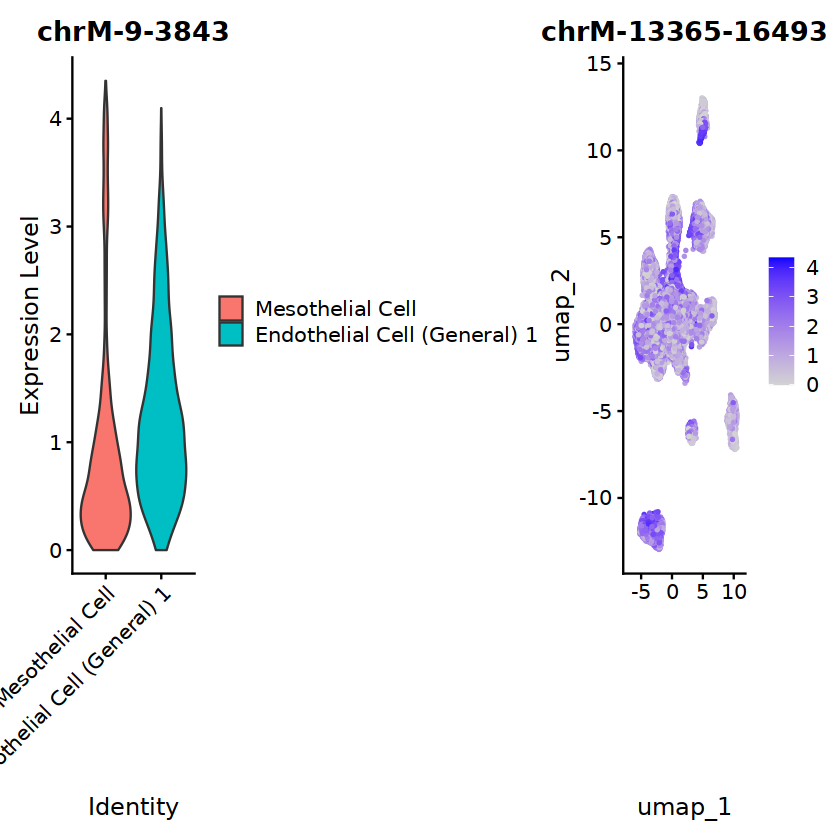

In [35]:
plot1 <- VlnPlot(
  object = seurat_object,
  features = rownames(da_peaks)[1],
  pt.size = 0,
  idents = c("Mesothelial Cell","Endothelial Cell (General) 1")
)
plot2 <- FeaturePlot(
  object = seurat_object,
  features = rownames(da_peaks)[2],
  pt.size = 0.5
)

plot1 | plot2



In [ ]:
#####################
#Find co-accessible peaks with cicero
###################
#seurat_object = qread("complete/GSE184462_merged_1_10_processed.rds")

In [ ]:
# convert to CellDataSet format and make the cicero object
DefaultAssay(seurat_object) <- "peaks"
seurat.cds <- as.cell_data_set(x = seurat_object)
cicero_object <- make_cicero_cds(seurat.cds, reduced_coordinates = reducedDims(seurat.cds)$UMAP)


########################
#Find Cicero connections
########################
# get the chromosome sizes from hg19
data(human.hg19.genome)
genome.df <- human.hg19.genome


# use chromosome 1 to save some time
# omit this step to run on the whole genome
#genome.df <- subset(human.hg19.genome, V1 == "chr18")

# run cicero
conns <- run_cicero(cicero_object, genomic_coords = genome.df, sample_num = 100)

########################
#Find cis-co-accessible networks (CCANs)
########################
ccans <- generate_ccans(conns)

########################
#Add links to a Seurat object
########################
links <- ConnectionsToLinks(conns = conns, ccans = ccans)
Links(seurat_object) <- links

Warning message in normarg_mcols(value, class(x), length(x)):
"You supplied a metadata column of length 2 to set on an object of
  length 223695. However please note that the latter is not a multiple of
  the former."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."


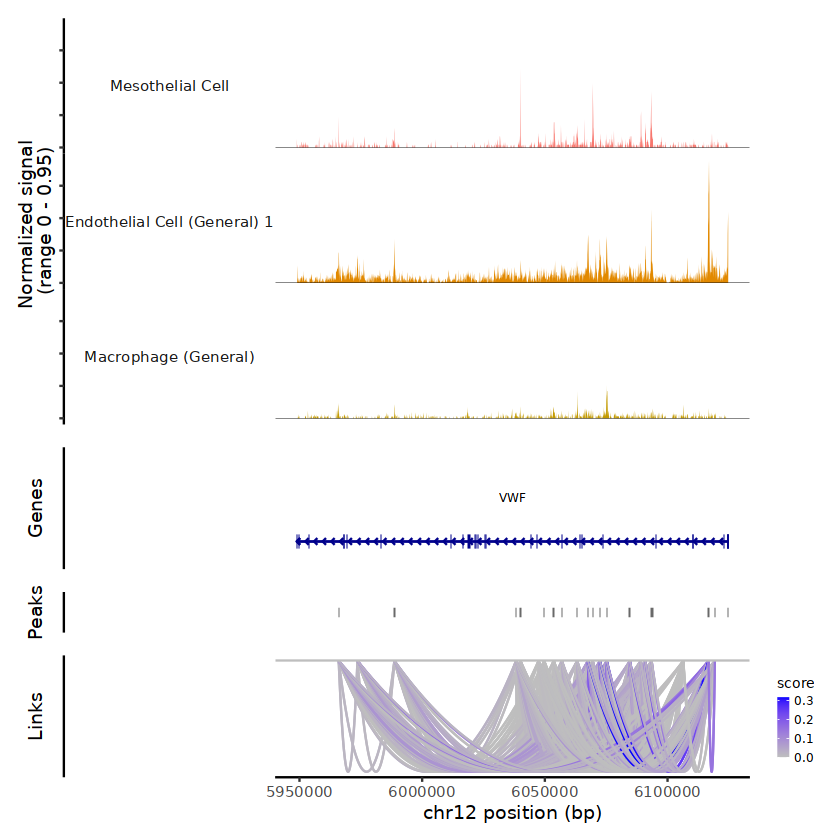

In [36]:
CoveragePlot(seurat_object, region = "VWF",
            idents = c("Mesothelial Cell", "Endothelial Cell (General) 1", "Macrophage (General)"))

In [6]:
#####################
#Motif analysis
###################
path <- paste("complete/", file, "_CoAc.rds", sep = "")
seurat_object = qread(path)

In [ ]:
#Removing scaffold debris
main.chroms <- standardChromosomes(BSgenome.Hsapiens.UCSC.hg38)
keep.peaks <- as.logical(seqnames(granges(seurat_object)) %in% main.chroms)
seurat_object[["peaks"]] <- subset(seurat_object[["peaks"]], features = rownames(seurat_object[["peaks"]])[keep.peaks])


#Get list of motifs
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)

# add motif information
seurat_object <- AddMotifs(
  object = seurat_object,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  pfm = pfm
)



In [37]:
ident_lyst <- unique(Idents(seurat_object))
ident_lyst

[1] Mesothelial Cell                       
 [2] Fibroblast (General)                   
 [3] Pericyte (General) 3                   
 [4] Pericyte (General) 1                   
 [5] Endothelial Cell (General) 1           
 [6] Endothelial Cell (General) 2           
 [7] Adipocyte                              
 [8] Lymphatic Endothelial Cell             
 [9] Macrophage (General)                   
[10] Pericyte (General) 2                   
[11] Pericyte (Esophageal Muscularis)       
[12] Macrophage (General,Alveolar)          
[13] T Lymphocyte 1 (CD8+)                  
[14] Vascular Smooth Muscle 2               
[15] Cardiac Pericyte 4                     
[16] Endothelial Cell (General) 3           
[17] Vascular Smooth Muscle 1               
[18] Cardiac Pericyte 3                     
[19] Naive T cell                           
[20] Schwann Cell (General)                 
[21] Pericyte (General) 4                   
[22] Cardiac Pericyte 2                     
[23] Plasma Cell                            
[24] Alverolar Type 2,Immune                
[25] Endothelial Cell (Myocardial)          
[26] Mast Cell                              
[27] Fibroblast (Peripheral Nerve)          
[28] Cardiac Fibroblasts                    
[29] Fibroblast (Epithelial)                
[30] Peripheral Nerve Stromal               
[31] Luteal Cell (Ovarian)                  
[32] Small Intestinal Enterocyte            
[33] Smooth Muscle (General)                
[34] Smooth Muscle (Esophageal Muscularis) 3
[35] Chief Cell                             
[36] Natural Killer T Cell                  
[37] T lymphocyte 2 (CD4+)                  
[38] Foveolar Cell                          
[39] Pancreatic Acinar Cell                 
[40] Alveolar Capillary Endothelial Cell    
[41] Ductal Cell (Pancreatic)               
[42] Memory B Cell                          
[43] Transitional Zone Cortical Cell        
[44] Cortical Epithelial-like               
[45] Zona Fasciculata Cortical Cell         
[46] Zona Glomerulosa Cortical Cell         
[47] Endothelial (Exocrine Tissues)         
[48] Fibroblast (Liver Adrenal)             
[49] CNS,Enteric Neuron                     
[50] Smooth Muscle (Vaginal)                
[51] Endocardial Cell                       
[52] Cardiac Pericyte 1                     
[53] Alveolar Type 2 (AT2) Cell             
[54] Keratinocyte 1                         
[55] Smooth Muscle (GE Junction)            
55 Levels: Mesothelial Cell Fibroblast (General) ... Smooth Muscle (GE Junction)

In [9]:
#find markers
DefaultAssay(seurat_object) <- "peaks"

da_peaks <- FindMarkers(
  object = seurat_object,
  ident.1 = ident_lyst[1],
  ident.2 = ident_lyst[2],
  only.pos = TRUE,
  test.use = 'LR',
  min.pct = 0.05,
  latent.vars = 'nCount_peaks'
)

# get top differentially accessible peaks
top.da.peak <- rownames(da_peaks[da_peaks$p_val < 0.005, ])

#Search for enriched motifs
enriched.motifs <- FindMotifs(
  object = seurat_object,
  features = top.da.peak,
)

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 1041 regions



Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the ggseqlogo package.
  Please report the issue at <https://github.com/omarwagih/ggseqlogo/issues>."


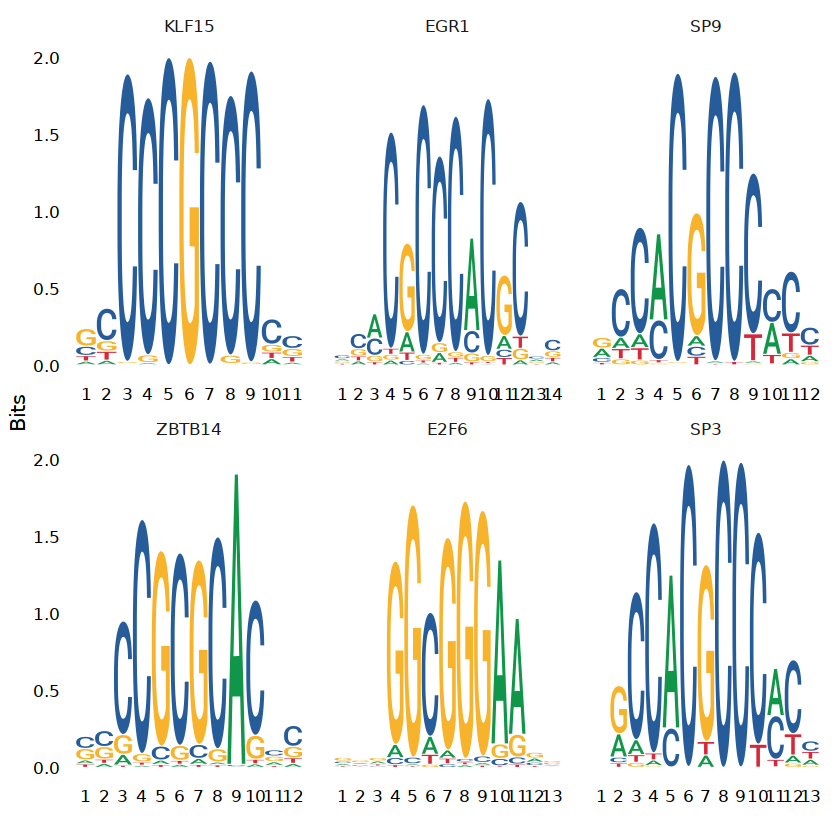

In [10]:
DefaultAssay(seurat_object) <- "peaks"
MotifPlot(
  object = seurat_object,
  motifs = head(rownames(enriched.motifs))
)

In [ ]:
###################
#Computing motif activities
###################
DefaultAssay(seurat_object) <- 'peaks'
seurat_object <- RunChromVAR(
  object = seurat_object,
  genome = BSgenome.Hsapiens.UCSC.hg38
)



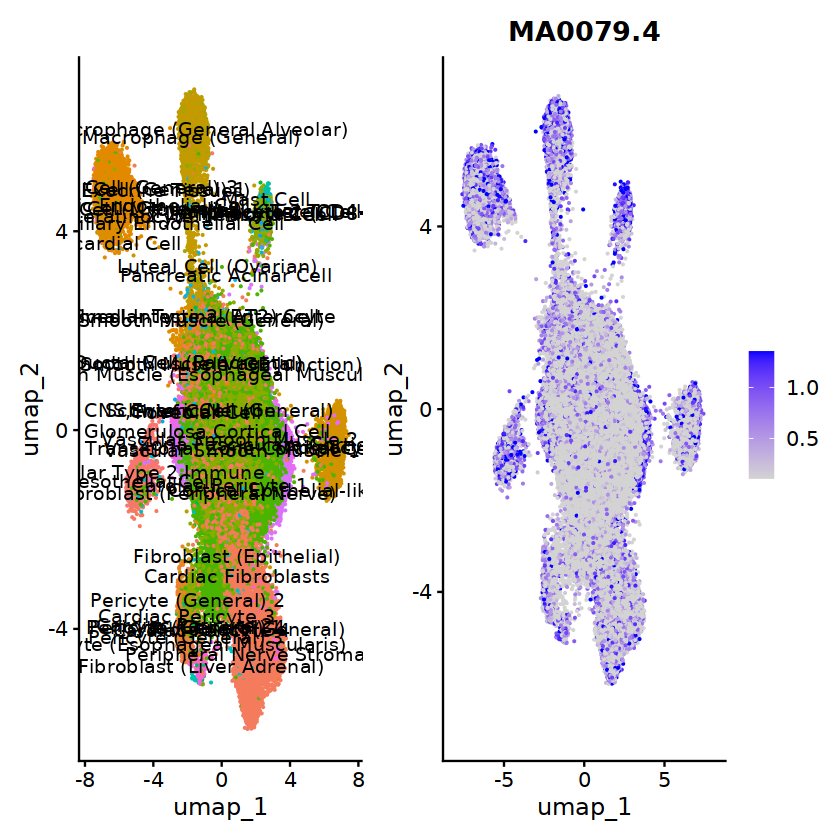

In [11]:
DefaultAssay(seurat_object) <- 'chromvar'
#Plot nomral dimension plot with clusters
p1 <- DimPlot(seurat_object, label = TRUE, pt.size = 0.1) + NoLegend()

p2 <- FeaturePlot(
  object = seurat_object,
  features = "MA0079.4",
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)
p1 + p2

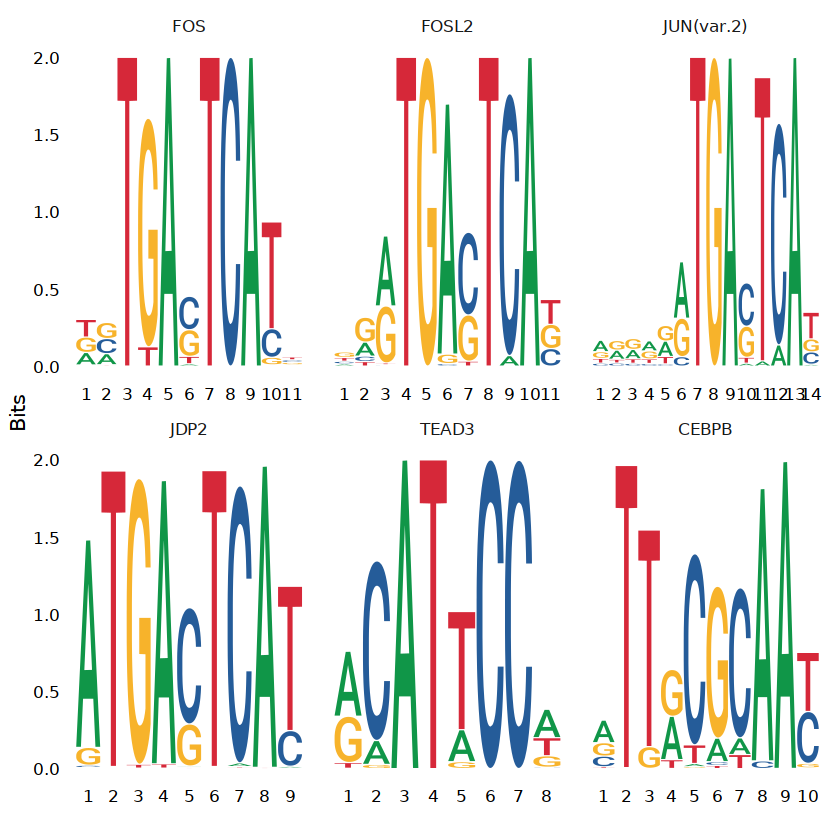

In [12]:
differential.activity <- FindMarkers(
  object = seurat_object,
  ident.1 = "Mesothelial Cell",
  ident.2 = "Endothelial Cell (General) 1",
  only.pos = TRUE,
  mean.fxn = rowMeans,
  fc.name = "avg_diff"
)

MotifPlot(
  object = seurat_object,
  motifs = head(rownames(differential.activity)),
  assay = 'peaks'
)

In [ ]:
#####################
#TF Footprinting
###################
path <- paste("report/", file, "_Motif.rds", sep = "")
#seurat_object = qread(path)

In [13]:
# gather the footprinting information for sets of motifs
DefaultAssay(seurat_object) <- "peaks"
seurat_object <- Footprint(
  object = seurat_object,
  motif.name = c("EGR1", "Wt1", "KLF5"),
  genome = BSgenome.Hsapiens.UCSC.hg38
)

Computing Tn5 insertion bias

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Computing observed Tn5 insertions per base

Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr1_GL383518v1_alt, chr1_GL383519v1_alt, chr1_GL383520v2_alt, chr1_KI270759v1_alt, chr1_KI270760v1_alt, chr1_KI270761v1_alt, chr1_KI270762v1_alt, chr1_KI270763v1_alt, chr1_KI270764v1_alt, chr1_KI270765v1_alt, chr1_KI270766v1_alt, chr1_KI270892v1_alt, chr2_GL383521v1_alt, chr2_GL383522v1_alt, chr2_GL582966v2_alt, chr2_KI270767v1_alt, chr2_KI270768v1_alt, chr2_KI270769v1_alt, chr2_KI270770v1_alt, chr2_KI27077

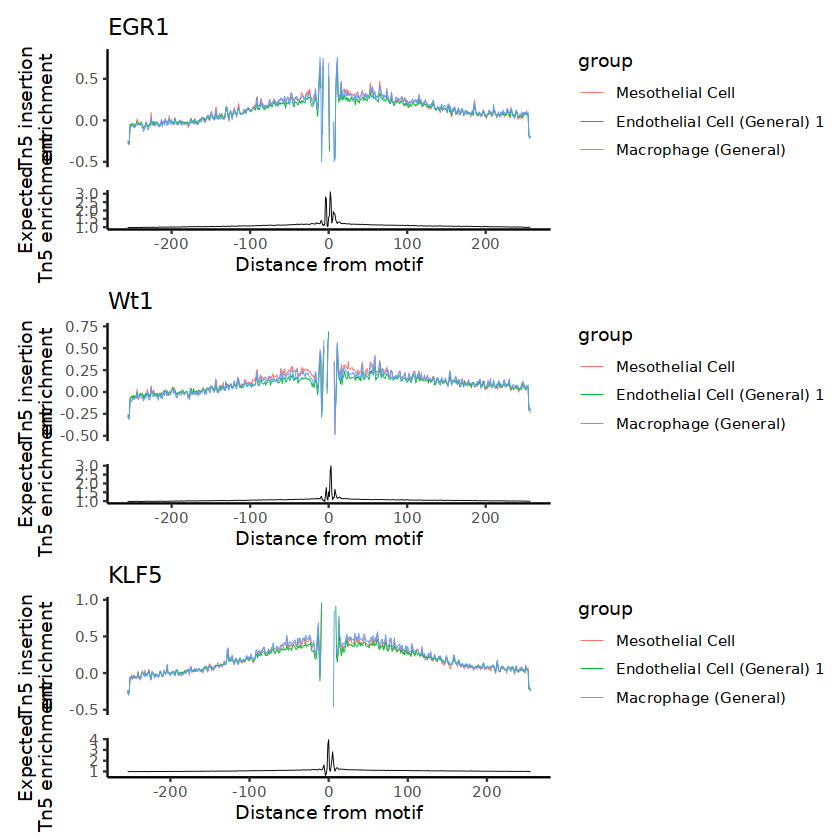

In [14]:
# plot the footprint data for each group of cells
p3 <- PlotFootprint(seurat_object, features = c("EGR1", "Wt1", "KLF5"), label = FALSE,
                    idents = c("Mesothelial Cell", "Endothelial Cell (General) 1", "Macrophage (General)"))
p4 <- p3+ patchwork::plot_layout(ncol = 1)
p4

In [ ]:
path <- paste("report/", file, "_TF_Footprinted.rds", sep = "")
#qsave(seurat_object, path)